In [10]:
import cv2
import numpy as np
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt


#import qr_extractor as reader


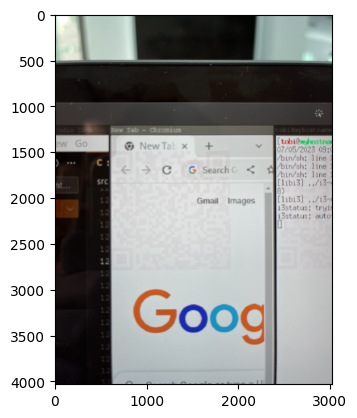

In [11]:

image = cv2.imread('phone12.jpg')

plt.imshow(image)

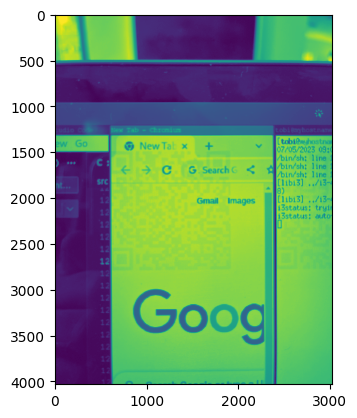

In [12]:

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)


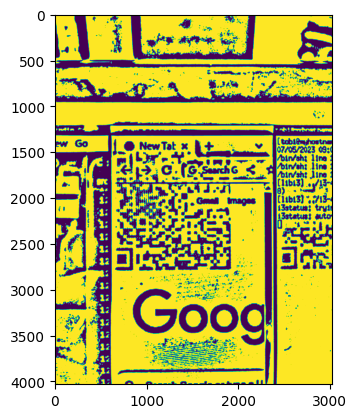

In [13]:

thresholded = cv2.equalizeHist(gray)
thresholded = cv2.blur(thresholded,(12,12))
alpha = 1.0 # Contrast control (1.0 for no change)
beta = 0  # Brightness control (0 for no change)
thresholded = cv2.convertScaleAbs(thresholded, alpha=alpha, beta=beta)


kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])  # Sharpening kernel
sharpened_image = cv2.filter2D(thresholded, -1, kernel)


thresholded = cv2.adaptiveThreshold(thresholded, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255,4)


kernel = np.ones((3, 3), np.uint8)  # Kernel for morphological operations
thresholded = cv2.erode(thresholded, kernel, iterations=1)
thresholded = cv2.dilate(thresholded, kernel, iterations=1)

# Display the masked image
plt.imshow(thresholded)


In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
import imutils
from pyzbar.pyzbar import decode


#from pyzbar.pyzbar import decode
#import qr_extractor as reader

def align_images(image, template, maxFeatures=5000, keepPercent=0.2):

	imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
	# use ORB to detect keypoints and extract (binary) local
	# invariant features
	orb = cv2.ORB_create(maxFeatures)
	(kpsA, descsA) = orb.detectAndCompute(imageGray, None)
	(kpsB, descsB) = orb.detectAndCompute(templateGray, None)
	# match the features
	method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
	matcher = cv2.DescriptorMatcher_create(method)
	matches = matcher.match(descsA, descsB, None)
    # sort the matches by their distance (the smaller the distance,
	# the "more similar" the features are)
	matches = sorted(matches, key=lambda x:x.distance)
	# keep only the top matches
	keep = int(len(matches) * keepPercent)
	matches = matches[:keep]
     # allocate memory for the keypoints (x, y)-coordinates from the
	# top matches -- we'll use these coordinates to compute our
	# homography matrix
	ptsA = np.zeros((len(matches), 2), dtype="float")
	ptsB = np.zeros((len(matches), 2), dtype="float")
	
    # loop over the top matches
	for (i, m) in enumerate(matches):
		# indicate that the two keypoints in the respective images
		# map to each other
		ptsA[i] = kpsA[m.queryIdx].pt
		ptsB[i] = kpsB[m.trainIdx].pt

	# compute the homography matrix between the two sets of matched
	# points
	(H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
	# use the homography matrix to align the images
	(h, w) = template.shape[:2]
	aligned = cv2.warpPerspective(image, H, (w, h))
	return aligned


def enhanceImage(image):
	# converting to LAB color space
	lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
	l_channel, a, b = cv2.split(lab)

	# Applying CLAHE to L-channel
	# feel free to try different values for the limit and grid size:
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	cl = clahe.apply(l_channel)

	# merge the CLAHE enhanced L-channel with the a and b channel
	limg = cv2.merge((cl,a,b))

	# Converting image from LAB Color model to BGR color spcae
	enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

	return enhanced_img
    
def fill_missing_lines(lines, image_shape):
    # Create a blank image with white background
    image = np.ones(image_shape, dtype=np.uint8) * 255

    # Iterate over the lines
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Draw the line on the image
        cv2.line(image, (x1, y1), (x2, y2), color=0, thickness=1)

    return image 

def restore_qr_code(lines):
    # Set the desired QR code size
    qr_code_size = 1920

    # Create a blank image with white background
    qr_code = np.ones((qr_code_size, qr_code_size), dtype=np.uint8) * 255

    # Iterate over the lines
    for line in lines:
        # Extract the start and end points of the line
        x1, y1, x2, y2 = line[0]

        # Calculate the line length and direction
        length = int(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2))
        angle = np.arctan2(y2 - y1, x2 - x1)

        # Iterate over the line and set the corresponding pixels in the QR code
        for i in range(length):
            x = int(x1 + i * np.cos(angle))
            y = int(y1 + i * np.sin(angle))
            qr_code[y, x] = 0

    return qr_code


thresh1 = None
diffScore = 0
diff1 = None
contours = None
for x in range(83):
	print(x)

	template = cv2.imread('frame' + str(x) + '.jpg')
	image = cv2.imread('frame' + str(x+1) + '.jpg')

	'''
	image = enhanceImage(image)	
	
	template = enhanceImage(template)
	image = enhanceImage(image)	
	template = enhanceImage(template)
	image = enhanceImage(image)	
	template = enhanceImage(template)
	image = enhanceImage(image)	


	'''
	overlay = template.copy()
	aligned = image #align_images(image, template)
	output = aligned.copy()

	#bits = 4  # Desired bit-depth
	#precision_factor = 2**(8 - bits)

	gray1 = cv2.cvtColor(overlay, cv2.COLOR_BGR2GRAY)
	gray2 = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)



	(score, diff) = compare_ssim(gray1, gray2,gaussian_weights=True, full=True)
	diff = (diff * 255).astype("uint8")
	print("SSIM: {}".format(score))
	if(.95 > score < diffScore):
		continue

	diffScore = score

	cv2.addWeighted(gray1, 0.5, gray2, 0.5, 0, gray2)

	(score, diff) = compare_ssim(gray1, gray2, full=True)
	diff = (diff * 255).astype("uint8")
	print("SSIM: {}".format(score))

	thresh1 = cv2.threshold(diff, 225, 255,
		cv2.THRESH_BINARY_INV)[1]
	diff1 = diff
	#cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	#	cv2.CHAIN_APPROX_SIMPLE)
	#cnts = imutils.grab_contours(cnts)
	diff1 = 255 - diff
	contours = cv2.findContours(diff1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	contours = contours[0] if len(contours) == 2 else contours[1]

	# draw white filled contour on black background

cv2.drawContours(overlay, contours, -1, (0, 255, 0), 3)
# Apply Canny edge detection
edges = cv2.Canny(thresh1, 50, 150)

# Detect lines using Hough transform
lines = cv2.HoughLinesP(thresh1, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
restored_qr_code = restored_qr_code = fill_missing_lines(lines, diff1.shape)
decoded_qr_codes = decode(thresh1)
# Access the decoded QR code data
if decoded_qr_codes:
    qr_code_data = decoded_qr_codes[0].data
    print("Decoded QR Code:", qr_code_data)
else:
    print("No QR Code found or could not be decoded.")

cv2.imshow("Diff", diff1)
cv2.imshow("canny", edges)

cv2.imshow("Contours", restored_qr_code)
cv2.imshow("Thresh", thresh1)
cv2.waitKey(0)
#gray1 = (gray1 // precision_factor) * precision_factor
#gray2 = (gray2 // precision_factor) * precision_factor

diff = cv2.absdiff(gray1, gray2)
#mask_inverse = cv2.bitwise_not(gray2)
#image_masked = cv2.bitwise_and(gray1, gray1, mask=mask_inverse)
blurred = cv2.GaussianBlur(diff, (1, 1), 0)
_, mask = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)


cv2.addWeighted(overlay, 0.5, output, 0.5, 0, output)

# Decode the QR code
#decoded = decode(mask)



# Check if any QR code is detected
#if decoded:
#    qr_code_data = decoded[0].data.decode('utf-8')
#    print('Decoded QR code:', qr_code_data)
#else:
#   print('No QR code detected.')

# Display the masked image
cv2.imwrite('overlay.png', output)
cv2.imwrite('output.png', diff)





exit
'''
# Convert the image to grayscale
gray1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

detector = cv2.ORB_create()
keypoints1, descriptors1 = detector.detectAndCompute(gray1, None)
keypoints2, descriptors2 = detector.detectAndCompute(gray2, None)

matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

matches = matcher.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

N = 50
selected_matches = matches[:N]

src_points = np.float32([keypoints1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)

M, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC)

aligned_image = cv2.warpPerspective(image2, M, (image.shape[1], image.shape[0]))

gray2 = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2GRAY)


diff = cv2.absdiff(gray1, gray2)

_, mask = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    

#thresholded = cv2.equalizeHist(gray)
#thresholded = cv2.blur(thresholded,(12,12))
#alpha = 1.0 # Contrast control (1.0 for no change)
#beta = 0  # Brightness control (0 for no change)
#thresholded = cv2.convertScaleAbs(thresholded, alpha=alpha, beta=beta)


#kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])  # Sharpening kernel
#sharpened_image = cv2.filter2D(thresholded, -1, kernel)


#thresholded = cv2.adaptiveThreshold(thresholded, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255,4)
def fu():
	return a

#kernel = np.ones((3, 3), np.uint8)  # Kernel for morphological operations
#thresholded = cv2.erode(thresholded, kernel, iterations=1)
#thresholded = cv2.dilate(thresholded, kernel, iterations=1)


#thresholded = (255-thresholded)



# Decode the QR code
#decoded = decode(thresholded)



# Check if any QR code is detected
#if decoded:
#    qr_code_data = decoded[0].data.decode('utf-8')
#    print('Decoded QR code:', qr_code_data)
#else:
#    print('No QR code detected.')

# Display the masked image





#PHONE 7
#thresholded = cv2.equalizeHist(gray)

#alpha = 1.0 # Contrast control (1.0 for no change)
#beta = 0  # Brightness control (0 for no change)
#thresholded = cv2.convertScaleAbs(thresholded, alpha=alpha, beta=beta)


#kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])  # Sharpening kernel
#sharpened_image = cv2.filter2D(thresholded, -1, kernel)


#thresholded = cv2.adaptiveThreshold(thresholded, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 255, 0)


#kernel = np.ones((15, 15), np.uint8)  # Kernel for morphological operations
#thresholded = cv2.erode(thresholded, kernel, iterations=1)
#thresholded = cv2.dilate(thresholded, kernel, iterations=1)'''

In [ ]:
import math

import cv2
import numpy as np

BLUR_VALUE = 3
SQUARE_TOLERANCE = 0.15
AREA_TOLERANCE = 0.15
DISTANCE_TOLERANCE = 0.25
WARP_DIM = 300
SMALL_DIM = 29


def count_children(hierarchy, parent, inner=False):
    if parent == -1:
        return 0
    elif not inner:
        return count_children(hierarchy, hierarchy[parent][2], True)
    return 1 + count_children(hierarchy, hierarchy[parent][0], True) + count_children(hierarchy, hierarchy[parent][2], True)


def has_square_parent(hierarchy, squares, parent):
    if hierarchy[parent][3] == -1:
        return False
    if hierarchy[parent][3] in squares:
        return True
    return has_square_parent(hierarchy, squares, hierarchy[parent][3])


def get_center(c):
    m = cv2.moments(c)
    return [int(m["m10"] / m["m00"]), int(m["m01"] / m["m00"])]


def get_angle(p1, p2):
    x_diff = p2[0] - p1[0]
    y_diff = p2[1] - p1[1]
    return math.degrees(math.atan2(y_diff, x_diff))


def get_midpoint(p1, p2):
    return [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]


def get_farthest_points(contour, center):
    distances = []
    distances_to_points = {}
    for point in contour:
        point = point[0]
        d = math.hypot(point[0] - center[0], point[1] - center[1])
        distances.append(d)
        distances_to_points[d] = point
    distances = sorted(distances)
    return [distances_to_points[distances[-1]], distances_to_points[distances[-2]]]


def line_intersection(line1, line2):
    x_diff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    y_diff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(x_diff, y_diff)
    if div == 0:
        return [-1, -1]

    d = (det(*line1), det(*line2))
    x = det(d, x_diff) / div
    y = det(d, y_diff) / div
    return [int(x), int(y)]


def extend(a, b, length, int_represent=False):
    length_ab = math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
    if length_ab * length <= 0:
        return b
    result = [b[0] + (b[0] - a[0]) / length_ab * length, b[1] + (b[1] - a[1]) / length_ab * length]
    if int_represent:
        return [int(result[0]), int(result[1])]
    else:
        return result


def extract(frame, debug=False):
    output = frame.copy()

    # Remove noise and unnecessary contours from frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    gray = cv2.GaussianBlur(gray, (BLUR_VALUE, BLUR_VALUE), 0)
    edged = cv2.Canny(gray, 30, 200)

    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    squares = []
    square_indices = []

    i = 0
    for c in contours:
        # Approximate the contour
        peri = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        approx = cv2.approxPolyDP(c, 0.03 * peri, True)

        # Find all quadrilateral contours
        if len(approx) == 4:
            # Determine if quadrilateral is a square to within SQUARE_TOLERANCE
            if area > 25 and 1 - SQUARE_TOLERANCE < math.fabs((peri / 4) ** 2) / area < 1 + SQUARE_TOLERANCE and count_children(hierarchy[0], i) >= 2 and has_square_parent(hierarchy[0], square_indices, i) is False:
                squares.append(approx)
                square_indices.append(i)
        i += 1

    main_corners = []
    east_corners = []
    south_corners = []
    tiny_squares = []
    rectangles = []
    # Determine if squares are QR codes
    for square in squares:
        area = cv2.contourArea(square)
        center = get_center(square)
        peri = cv2.arcLength(square, True)

        similar = []
        tiny = []
        for other in squares:
            if square[0][0][0] != other[0][0][0]:
                # Determine if square is similar to other square within AREA_TOLERANCE
                if math.fabs(area - cv2.contourArea(other)) / max(area, cv2.contourArea(other)) <= AREA_TOLERANCE:
                    similar.append(other)
                elif peri / 4 / 2 > cv2.arcLength(other, True) / 4:
                    tiny.append(other)

        if len(similar) >= 2:
            distances = []
            distances_to_contours = {}
            for sim in similar:
                sim_center = get_center(sim)
                d = math.hypot(sim_center[0] - center[0], sim_center[1] - center[1])
                distances.append(d)
                distances_to_contours[d] = sim
            distances = sorted(distances)
            closest_a = distances[-1]
            closest_b = distances[-2]

            # Determine if this square is the top left QR code indicator
            if max(closest_a, closest_b) < cv2.arcLength(square, True) * 2.5 and math.fabs(closest_a - closest_b) / max(closest_a, closest_b) <= DISTANCE_TOLERANCE:
                # Determine placement of other indicators (even if code is rotated)
                angle_a = get_angle(get_center(distances_to_contours[closest_a]), center)
                angle_b = get_angle(get_center(distances_to_contours[closest_b]), center)
                if angle_a < angle_b or (angle_b < -90 and angle_a > 0):
                    east = distances_to_contours[closest_a]
                    south = distances_to_contours[closest_b]
                else:
                    east = distances_to_contours[closest_b]
                    south = distances_to_contours[closest_a]
                midpoint = get_midpoint(get_center(east), get_center(south))
                # Determine location of fourth corner
                # Find closest tiny indicator if possible
                min_dist = 10000
                t = []
                tiny_found = False
                if len(tiny) > 0:
                    for tin in tiny:
                        tin_center = get_center(tin)
                        d = math.hypot(tin_center[0] - midpoint[0], tin_center[1] - midpoint[1])
                        if d < min_dist:
                            min_dist = d
                            t = tin
                    tiny_found = len(t) > 0 and min_dist < peri

                diagonal = peri / 4 * 1.41421

                if tiny_found:
                    # Easy, corner is just a few blocks away from the tiny indicator
                    tiny_squares.append(t)
                    offset = extend(midpoint, get_center(t), peri / 4 * 1.41421)
                else:
                    # No tiny indicator found, must extrapolate corner based off of other corners instead
                    farthest_a = get_farthest_points(distances_to_contours[closest_a], center)
                    farthest_b = get_farthest_points(distances_to_contours[closest_b], center)
                    # Use sides of indicators to determine fourth corner
                    offset = line_intersection(farthest_a, farthest_b)
                    if offset[0] == -1:
                        # Error, extrapolation failed, go on to next possible code
                        continue
                    offset = extend(midpoint, offset, peri / 4 / 7)
                    if debug:
                        cv2.line(output, (farthest_a[0][0], farthest_a[0][1]), (farthest_a[1][0], farthest_a[1][1]), (0, 0, 255), 4)
                        cv2.line(output, (farthest_b[0][0], farthest_b[0][1]), (farthest_b[1][0], farthest_b[1][1]), (0, 0, 255), 4)

                # Append rectangle, offsetting to farthest borders
                rectangles.append([extend(midpoint, center, diagonal / 2, True), extend(midpoint, get_center(distances_to_contours[closest_b]), diagonal / 2, True), offset, extend(midpoint, get_center(distances_to_contours[closest_a]), diagonal / 2, True)])
                east_corners.append(east)
                south_corners.append(south)
                main_corners.append(square)

    codes = []
    i = 0
    for rect in rectangles:
        i += 1
        # Draw rectangle
        vrx = np.array((rect[0], rect[1], rect[2], rect[3]), np.int32)
        vrx = vrx.reshape((-1, 1, 2))
        cv2.polylines(output, [vrx], True, (0, 255, 255), 1)
        # Warp codes and draw them
        wrect = np.zeros((4, 2), dtype="float32")
        wrect[0] = rect[0]
        wrect[1] = rect[1]
        wrect[2] = rect[2]
        wrect[3] = rect[3]
        dst = np.array([
            [0, 0],
            [WARP_DIM - 1, 0],
            [WARP_DIM - 1, WARP_DIM - 1],
            [0, WARP_DIM - 1]], dtype="float32")
        warp = cv2.warpPerspective(frame, cv2.getPerspectiveTransform(wrect, dst), (WARP_DIM, WARP_DIM))
        # Increase contrast
        warp = cv2.bilateralFilter(warp, 11, 17, 17)
        warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
        small = cv2.resize(warp, (SMALL_DIM, SMALL_DIM), 0, 0, interpolation=cv2.INTER_CUBIC)
        _, small = cv2.threshold(small, 100, 255, cv2.THRESH_BINARY)
        codes.append(small)
        if debug:
            cv2.imshow("Warped: " + str(i), small)

    if debug:
        # Draw debug information onto frame before outputting it
        cv2.drawContours(output, squares, -1, (5, 5, 5), 2)
        cv2.drawContours(output, main_corners, -1, (0, 0, 128), 2)
        cv2.drawContours(output, east_corners, -1, (0, 128, 0), 2)
        cv2.drawContours(output, south_corners, -1, (128, 0, 0), 2)
        cv2.drawContours(output, tiny_squares, -1, (128, 128, 0), 2)

    return codes, output
